In [1]:
import json
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford

In [2]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

num_qubit = 4

# Sanity check on the all-z expectation value of the generated random Cliffords

In [ ]:
from qiskit.transpiler.exceptions import TranspilerError

out = []
for _ in tqdm_notebook(range(1000)):
    d = random.choice(np.arange(0, 19, 2))
    circuit, _ = construct_random_clifford(num_qubit, d)

    success = False
    while not success:
        try:
            circuit = transpile(circuit, backend_noisy, optimization_level=3)
            success = True
        except TranspilerError as e:
            print(f'Run into {e}')

    job_ideal = execute(circuit, **run_config_ideal)
    counts_ideal = job_ideal.result().get_counts()
    ideal_exp_val = cal_all_z_exp(counts_ideal)
    out.append(ideal_exp_val)

Text(0.5, 1.0, '1000 "random" clifford all-Z expectation')

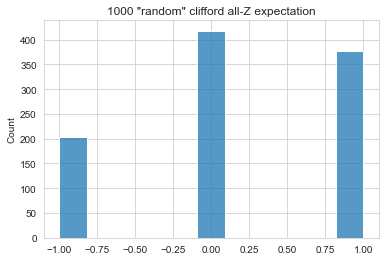

In [6]:
sns.histplot(out)
plt.title('1000 "random" clifford all-Z expectation')

# Generate cliffords

In [3]:
num_qubit = 4

def construct_random_clifford_func(two_q_gate_depth_post_trans, factor=1.2):
    if not two_q_gate_depth_post_trans:
        d = np.random.randint(1, 6)
        rc = transpile(construct_random_clifford(num_qubit, d, max_operands=1)[0], backend=backend_noisy, optimization_level=3)

    elif 1 <= two_q_gate_depth_post_trans <= 8:
        d = np.random.randint(1, two_q_gate_depth_post_trans//factor)
        rc = transpile(construct_random_clifford(num_qubit, d)[0], backend=backend_noisy, optimization_level=3)
        while rc.depth(filter_function=lambda x: x[0].num_qubits == 2) != two_q_gate_depth_post_trans:
            d = np.random.randint(1, two_q_gate_depth_post_trans//factor)
            rc = transpile(construct_random_clifford(num_qubit, d)[0], backend=backend_noisy, optimization_level=3)

    elif 8 <= two_q_gate_depth_post_trans <= 18:
        d = np.random.randint(5, two_q_gate_depth_post_trans//factor)
        rc = transpile(construct_random_clifford(num_qubit, d)[0], backend=backend_noisy, optimization_level=3)
        while rc.depth(filter_function=lambda x: x[0].num_qubits == 2) != two_q_gate_depth_post_trans:
            d = np.random.randint(5, two_q_gate_depth_post_trans//factor)
            rc = transpile(construct_random_clifford(num_qubit, d)[0], backend=backend_noisy, optimization_level=3)
    else:
        raise NotImplementedError
    return rc

In [8]:
depths = [14]
generate_data(construct_random_clifford_func, depths, './data/haoran_mbd/random_cliffords', 500)

  0%|          | 0/500 [00:00<?, ?it/s]

Ran into an error:, eig algorithm (geev) did not converge (only eigenvalues with order >= 2 have converged)


# Random Circuit

In [23]:
num_qubit = 4

def construct_random_circuit(two_q_gate_depth_post_trans, factor=2):
    if not two_q_gate_depth_post_trans:
        d = np.random.randint(1, 6)
        rc = transpile(random_circuit(num_qubit, d, 1, measure=True), backend=backend_noisy, optimization_level=3)

    elif 1 <= two_q_gate_depth_post_trans <= 8:
        d = np.random.randint(1, two_q_gate_depth_post_trans//factor)
        rc = transpile(random_circuit(num_qubit, d, 2, measure=True), backend=backend_noisy, optimization_level=3)
        while rc.depth(filter_function=lambda x: x[0].num_qubits == 2) != two_q_gate_depth_post_trans:
            d = np.random.randint(1, two_q_gate_depth_post_trans//factor)
            rc = transpile(random_circuit(num_qubit, d, 2, measure=True), backend=backend_noisy, optimization_level=3)

    elif 8 <= two_q_gate_depth_post_trans <= 18:
        d = np.random.randint(5, two_q_gate_depth_post_trans//factor)
        rc = transpile(random_circuit(num_qubit, d, 2, measure=True), backend=backend_noisy, optimization_level=3)
        while rc.depth(filter_function=lambda x: x[0].num_qubits == 2) != two_q_gate_depth_post_trans:
            d = np.random.randint(5, two_q_gate_depth_post_trans//factor)
            rc = transpile(random_circuit(num_qubit, d, 2, measure=True), backend=backend_noisy, optimization_level=3)
    else:
        raise NotImplementedError
    return rc

In [20]:
# circuit = transpile(construct_random_circuit(2), backend=backend_noisy, optimization_level=3)
circuit = construct_random_circuit(4)
circuit.draw(fold=-1)

ancilla_0 -> 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               ┌────────────────────────┐               ┌───┐          ┌─────────────┐    ┌────┐    ┌──────────────┐┌────┐┌───┐┌────┐┌────────────┐┌────┐    ┌──────────────┐    ┌───┐┌────────────┐    ┌───┐      ┌────────────┐      ┌─┐                                        
      q_1 -> 1 ┤ Rz(0.0239236197528316) ├───────────────┤ X ├──────────┤ Rz(0.68664) ├────┤ √X ├────┤ Rz(-0.95527) ├┤ √X ├┤ X ├┤ √X ├┤ Rz(2.1863) ├┤ √X ├────┤ Rz(-0.86024) ├────┤ X ├┤ Rz(1.3214) ├────┤ X ├──────┤ Rz(2.7257) ├──────┤M├────────────────────────────────────────
               └────┬─────────────┬─────┘┌────┐         └─┬─┘          ├─────────────┤    ├────┤    └┬────────────┬┘└────┘└─┬─┘└────┘└────────────┘└────┘    └──────────────┘    └─┬─┘└───┬───┬────┘    └─┬─┘     ┌┴────────────┤┌────┐└╥┘┌─────────────┐┌────┐┌──────────────┐┌─┐
      q_2 -> 2 ─────┤ Rz(0.27725) ├──────┤ √X ├───────────┼────────────┤ Rz(-1.8184) ├────┤ √X ├─────┤ Rz(1.4965) ├─────────┼──────────────────────────────────────────────────────■──────┤ X ├───────────■───────┤ Rz(0.17503) ├┤ √X ├─╫─┤ Rz(-1.3231) ├┤ √X ├┤ Rz(-0.27725) ├┤M├
                    └┬────────────┤      └────┘           │            └─────────────┘    └────┘     └────────────┘         │  ┌────┐ ┌─────────┐  ┌───┐ ┌──────────────────────┐┌───┐ ┌──┴───┴──┐      ┌────┐    └─┬─────────┬─┘└┬─┬─┘ ║ └─────────────┘└────┘└──────────────┘└╥┘
      q_0 -> 3 ──────┤ Rz(4.0258) ├───────────────────────■─────────────────────────────────────────────────────────────────■──┤ √X ├─┤ Rz(π/2) ├──┤ X ├─┤ Rz(4.43075392342824) ├┤ X ├─┤ Rz(π/2) ├──────┤ √X ├──────┤ Rz(π/2) ├───┤M├───╫───────────────────────────────────────╫─
                ┌────┴────────────┴────┐ ┌────┐┌──────────────────────┐     ┌────┐    ┌────────────┐                           └────┘ └─────────┘  └─┬─┘ └──────────────────────┘└─┬─┘ └──┬────┬─┘  ┌───┴────┴───┐  └──┬────┬─┘   └╥┘   ║       ┌─┐                             ║ 
      q_3 -> 4 ─┤ Rz(3.55040409264697) ├─┤ √X ├┤ Rz(4.98231699874079) ├─────┤ √X ├────┤ Rz(6.8116) ├─────────────────────────────────────────────────■─────────────────────────────■──────┤ √X ├────┤ Rz(2.8656) ├─────┤ √X ├──────╫────╫───────┤M├─────────────────────────────╫─
                └──────────────────────┘ └────┘└──────────────────────┘     └────┘    └────────────┘                                                                                      └────┘    └────────────┘     └────┘      ║    ║       └╥┘                             ║ 
          c: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩════╩════════╩══════════════════════════════╩═
                                                                                                                                                                                                                                   0    1        3                              2

In [110]:
transpile(circuit, backend_noisy, optimization_level=3).depth(lambda x: x[0].num_qubits == 2)

8

In [9]:
from qiskit.transpiler.exceptions import TranspilerError
import scipy

def generate_data(generating_func, two_q_gate_depths, save_path: str, n_entries_per_file: int):
    for depth in two_q_gate_depths:
        entries = []

        for i in tqdm_notebook(range(n_entries_per_file)):
            success = False
            while not success:
                try:
                    circuit = generating_func(depth)
                    success = True
                except (scipy.linalg.LinAlgError, TranspilerError, np.linalg.LinAlgError) as e:
                    print(f"Ran into an error:, {e}")

            job_ideal = execute(circuit, **run_config_ideal)
            job_noisy = execute(circuit, **run_config_noisy)

            counts_ideal = job_ideal.result().get_counts()
            counts_noisy = job_noisy.result().get_counts()

            ideal_exp_val = cal_z_exp(counts_ideal)
            noisy_exp_val = cal_z_exp(counts_noisy)

            graph_data = circuit_to_graph_data_json(
                circuit=circuit,
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )

            entry = ExpValueEntry(
                circuit_graph=graph_data,
                observable=[],
                ideal_exp_value=ideal_exp_val.tolist(),
                noisy_exp_values=[noisy_exp_val.tolist()],
                circuit_depth=circuit.depth()
            )
            entries.append(entry.to_dict())

        path = f"{save_path}/depth{depth}.json"
        with open(path, "w") as f:
            # pprint(entries)
            json.dump(entries, f)

In [ ]:
depths = [16]
generate_data(construct_random_circuit, depths, './data/haoran_mbd/random_circuits', 500)

In [24]:
f = open('./data/haoran_mbl/rc_train/random_circuits_depth4.json')
out = json.load(f)

# Random Brickwork

In [19]:
num_qubit = 4

def construct_random_brickwork_func(num_steps):
    num_qubit = 4
    rb = construct_mbl_circuit(num_qubit, [], 0, num_steps, completely_random=True)
    # rb = transpile(rb, backend=backend_noisy, optimization_level=3)
    return rb

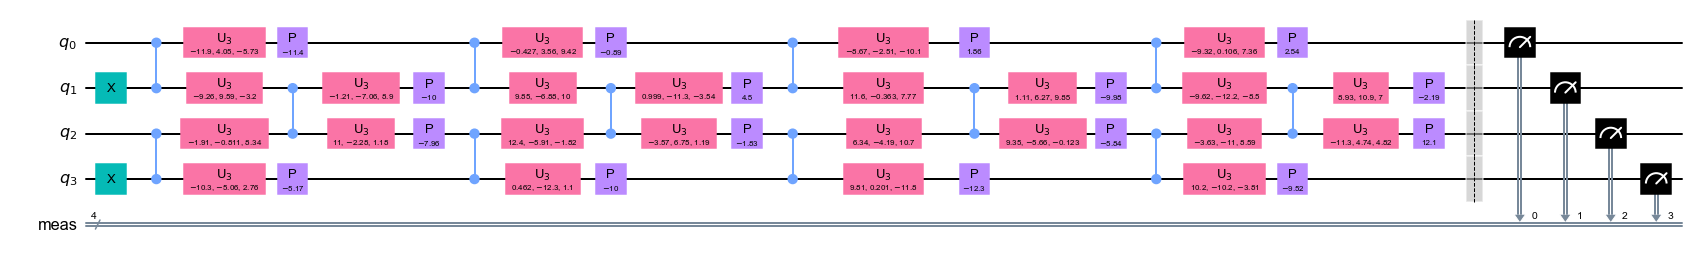

In [23]:
construct_random_brickwork_func(4).draw('mpl', fold=-1)


In [16]:
steps = list(range(10))
generate_data(construct_random_brickwork_func, steps, './data/haoran_mbd/random_brickwork/val', 200)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]